# State estimation with the starman library

## The Kalman filter

A very popular state estimation algorithm is the [Kalman
filter](https://en.wikipedia.org/wiki/Kalman_filter). The Kalman filter
can be used when the dynamics of a system are linear and measurements
are some linear function of state.

### Problem formulation

Let's first refresh the goal of the Kalman filter and its formulation.
The Kalman filter attempts to update an estimate of the "true" state of
a system given noisy measurements of the state. The state is assumed to
evolve in a linear way and measurements are assumed to be linear
functions of the state. Specifically, it is assumed that the "true"
state at time $k+1$ is a function of the "true" state at time \`k\`:

$$x_{k+1} = F_k x_k + B_k u_k + w_k$$

where $w_k$ is a sample from a zero-mean Gaussian process with
covariance $Q_k$. We term $Q_k$ the *process covariance*. The matrix
$F_k$ is termed the *state-transition matrix* and determines how the
state evolves. The matrix $B_k$ is the *control matrix* and determines
the contribution to the state of the control input, $u_k$.

At time instant $k$ we may have zero or more *measurements* of the
state. Each measurement, $z_k$ is assumed to be a linear function of the
state:

$$z_k = H_k x_k + v_k$$

where $H_k$ is termed the *measurement matrix* and $v_k$ is a sample
from a zero-mean Gaussian process with covariance $R_k$. We term $R_k$
the *measurement covariance*.

The Kalman filter maintains for time instant, $k$, an *a priori*
estimate of state, $\hat{x}_{k|k-1}$ covariance of this estimate,
$P_{k|k-1}$. The initial values of these parameters are given when the
Kalman filter is created. The filter also maintains an *a posteriori*
estimate of state, $\hat{x}_{k|k}$, and covariance, $P_{k|k}$. This is
updated for each measurement, $z_k$.

Mathematical overview
---------------------

The Kalman filter alternates between a *predict* step for each time step
and zero or more *update* steps. The predict step forms an *a priori*
estimate of the state given the dynamics of the system and the update
step refines an *a posteriori* estimate given the measurement.

### *A Priori* Prediction

At time $k$ we are given a state transition matrix, $F_k$, and estimate
of the *process noise*, $Q_k$. Our *a priori* estimates are then given
by:

$$\hat{x}_{k|k-1} = F_k \hat{x}_{k-1|k-1} + B_k u_k,
 \quad
 P_{k|k-1} = F_k P_{k-1|k-1} F_k^T + Q_k.$$

### Innovation

At time $k$ we are given a matrix, $H_k$, which specifies how a given
measurement is derived from the state and some estimate of the
measurement noise covariance, $R_k$. We may now compute the innovation,
$y_k$, of the measurement from the predicted measurement and our
expected innovation covariance, \`S\_k\`:

$$y_k = z_k - H_k \hat{x}_{k|k-1}, \quad S_k = H_k P_{k|k-1} H_k^T + R_k.$$

### Update

We now update the state estimate with the measurement via the so-called
*Kalman gain*, \`K\_k\`:

$$K_k = P_{k|k-1} H_k^T S_k^{-1}.$$

Merging is straightforward. Note that if we have no measurement, our *a
posteriori* estimate reduces to the *a priori* one:

$$\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k y_k, \quad P_{k|k} = P_{k|k-1} - K_k
H_k P_{k|k-1}.$$

## Preparing the environment

Start by importing the "pylab" environment which imports numpy and matplotlib for us. Some additional utilities are implemented in the "plotutils" file.

In [1]:
# Import matplotlib and numpy and enable inline plotting
%pylab notebook

# Import some plotting utility functions
from plotutils import *

# Set default figure size
rcParams['figure.figsize'] = (9, 7)

Populating the interactive namespace from numpy and matplotlib


In order to provide consistent results, we also set the random seed to a "nothing up our sleeves" value.

In [2]:
# Make sure we use a known seed for consistent results
np.random.seed(0xdeadbeef)

## Example: the constant velocity model

### Generating the true states

We will implement a simple 2D state estimation problem using the
constant velocity model. The state transition matrix is constant
throughout the model:

In [3]:
# Import numpy and matplotlib functions into global namespace
from matplotlib.pylab import *

# Our state is x-position, y-position, x-velocity and y-velocity.
# The state evolves by adding the corresponding velocities to the
# x- and y-positions.
F = array([
    [1, 0, 1, 0], # x <- x + vx
    [0, 1, 0, 1], # y <- y + vy
    [0, 0, 1, 0], # vx is constant
    [0, 0, 0, 1], # vy is constant
])

# Specify the length of the state vector
STATE_DIM = F.shape[0]

Let's generate some sample data by determining the process noise
covariance:

In [4]:
# Specify the process noise covariance
Q = diag([1e-2, 1e-2, 1e-1, 1e-1]) ** 2

# How many states should we generate?
N = 100

# Generate some "true" states
from starman.linearsystem import generate_states
true_states = generate_states(N, process_matrix=F, process_covariance=Q)
assert true_states.shape == (N, STATE_DIM)

We can plot the true states we've just generated:

In [5]:
import matplotlib.gridspec as gridspec

# Convenience function to set up our plotting axes
def create_axes():
    gs = gridspec.GridSpec(2, 2)
    ax_x = subplot(gs[0, 0])
    ax_y = subplot(gs[0, 1], sharey=ax_x)
    ax_vx = subplot(gs[1, 0], sharex=ax_x)
    ax_vy = subplot(gs[1, 1], sharex=ax_y, sharey=ax_vx)

    ax_x.set_xlabel("Time step")
    ax_x.set_ylabel("X co-ordinate")
    ax_x.grid(True)
    ax_y.set_xlabel("Time step")
    ax_y.set_ylabel("Y co-ordinate")
    ax_y.grid(True)
    ax_vx.set_ylabel("X velocity")
    ax_vx.set_xlabel("Time step")
    ax_vx.grid(True)
    ax_vy.set_ylabel("Y velocity")
    ax_vy.set_xlabel("Time step")
    ax_vy.grid(True)

    return ax_x, ax_y, ax_vx, ax_vy

<IPython.core.display.Javascript object>


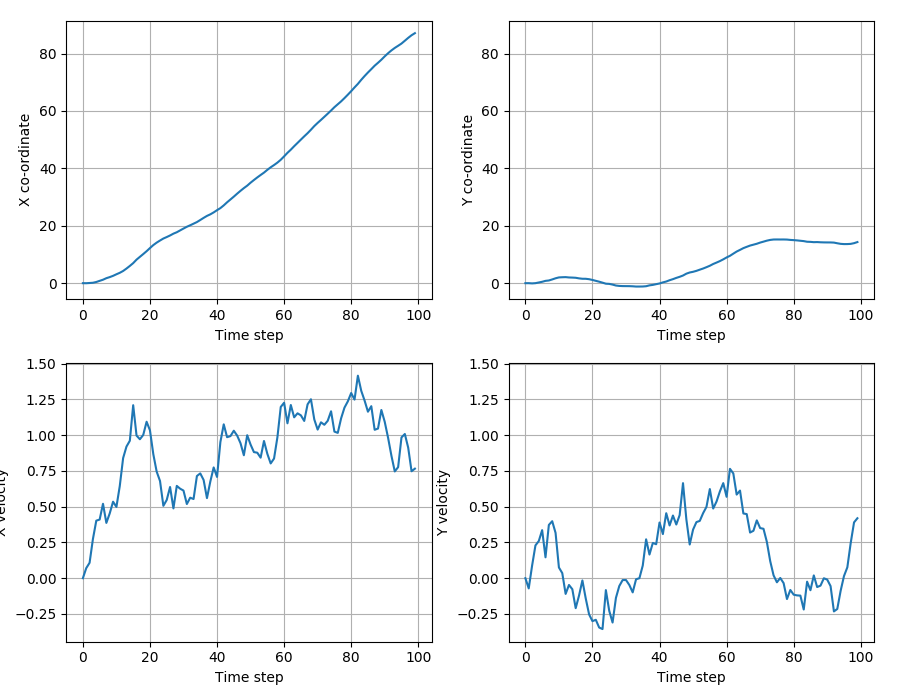

In [6]:
figure()
ax_x, ax_y, ax_vx, ax_vy = create_axes()
tight_layout()

sca(ax_x); plot(true_states[:, 0])
sca(ax_y); plot(true_states[:, 1])
sca(ax_vx); plot(true_states[:, 2])
sca(ax_vy); plot(true_states[:, 3])

### Generating measurements

We will use a measurement model where the velocity is a "hidden" state
and we can only directly measure position. We'll also specify a
measurement error covariance.

In [7]:
# We only measure position
H = array([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
])

# And we measure with some error. Note that we have difference
# variances for x and y.
R = diag([1.0, 2.0]) ** 2

# Specify the measurement vector length
MEAS_DIM = H.shape[0]

From the measurement matrix and measurement error we can generate noisy
measurements from the true states.

In [8]:
# Measure the states
from starman.linearsystem import measure_states
measurements = measure_states(true_states, measurement_matrix=H,
                              measurement_covariance=R)

Let's plot the measurements overlaid on the true states.

<IPython.core.display.Javascript object>


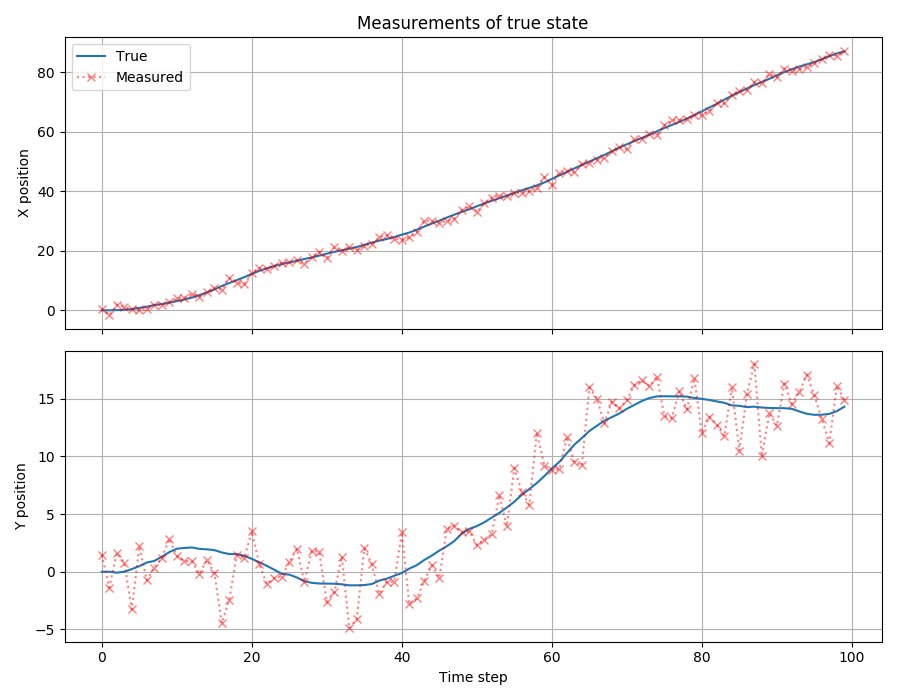

In [9]:
figure()
ax1 = subplot(2, 1, 1)
plot(true_states[:, 0], label="True")
plot(measurements[:, 0], 'rx:', label="Measured", alpha=0.5)
setp(ax1.get_xticklabels(), visible=False)
ylabel('X position'); grid(True); legend(loc="best")
title('Measurements of true state')

subplot(2, 1, 2, sharex=ax1)
plot(true_states[:, 1])
plot(measurements[:, 1], 'rx:', alpha=0.5)
ylabel('Y position'); grid(True); xlabel('Time step')

tight_layout()

### Using the Kalman filter

We can create an instance of the KalmanFilter class to filter our
noisy measurements.

In [10]:
from starman import KalmanFilter, MultivariateNormal

# Create a kalman filter with constant process matrix and covariances.
kf = KalmanFilter(state_length=STATE_DIM,
                  process_matrix=F, process_covariance=Q)

# For each time step
for k, z in enumerate(measurements):
    # Predict state for this timestep
    kf.predict()

    # Update filter with measurement
    kf.update(measurement=MultivariateNormal(mean=z, cov=R),
              measurement_matrix=H)

The :pystarman.KalmanFilter class has a number of attributes which give
useful information on the filter:

In [11]:
# Check that filter length is as expected
assert kf.state_count == N

# Check that the filter state dimension is as expected
assert kf.state_length == STATE_DIM

Now we've run the filter, we can see how it has performed. We also shade
the three sigma regions for the estimates.

<IPython.core.display.Javascript object>


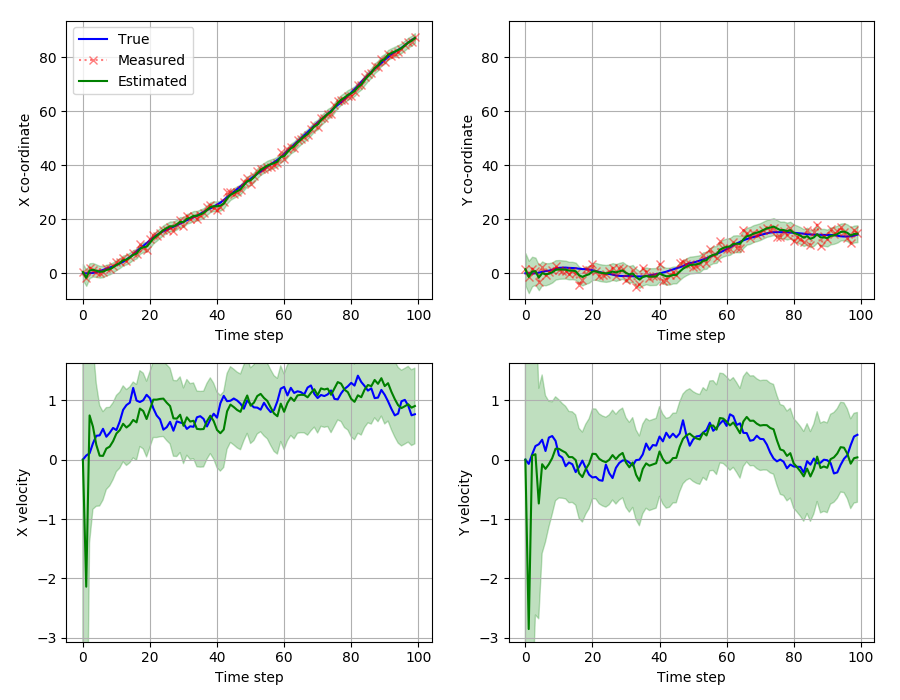

In [12]:
# Stack all the estimate means from the filter into an NxSTATE_DIM array
estimates = vstack([d.mean for d in kf.posterior_state_estimates])
assert estimates.shape == (N, STATE_DIM)

# Stack all the estimate covariances into an NxSTATE_DIMxSTATE_DIM array.
estimate_covs = vstack(d.cov[newaxis, ...] for d in kf.posterior_state_estimates)
assert estimate_covs.shape == (N, STATE_DIM, STATE_DIM)

# Get array of timesteps
ks = np.arange(estimates.shape[0])

figure()
ax_x, ax_y, ax_vx, ax_vy = create_axes()
tight_layout()

sca(ax_x)
plot(true_states[:, 0], 'b', label="True")
plot(measurements[:, 0], 'rx:', label="Measured", alpha=0.5)
plot(estimates[:, 0], 'g', label="Estimated")
gca().autoscale(False)
plot_vars(ks, estimates[:, 0], estimate_covs[:, 0, 0],
          color='g', alpha=0.25, zorder=-1)
legend(loc="best")

sca(ax_y)
plot(true_states[:, 1], 'b', label="True")
plot(measurements[:, 1], 'rx:', label="Measured", alpha=0.5)
plot(estimates[:, 1], 'g', label="Estimated")
gca().autoscale(False)
plot_vars(ks, estimates[:, 1], estimate_covs[:, 1, 1],
          color='g', alpha=0.25, zorder=-1)

sca(ax_vx)
plot(true_states[:, 2], 'b', label="True")
plot(estimates[:, 2], 'g', label="Estimated")

sca(ax_vy)
plot(true_states[:, 3], 'b', label="True")
plot(estimates[:, 3], 'g', label="Estimated")

ax_vy.autoscale(False)
sca(ax_vy)
plot_vars(ks, estimates[:, 3], estimate_covs[:, 3, 3],
          color='g', alpha=0.25, zorder=-1)

ax_vx.autoscale(False)
sca(ax_vx)
plot_vars(ks, estimates[:, 2], estimate_covs[:, 2, 2],
          color='g', alpha=0.25, zorder=-1)


We see that the estimates of position and velocity improve over time.

Rauch-Tung-Striebel smoothing
-----------------------------

The
[Rauch-Tung-Striebel](https://en.wikipedia.org/wiki/Kalman_filter#Rauch.E2.80.93Tung.E2.80.93Striebel)
(RTS) smoother provides a method of computing the "all data" *a
posteriori* estimate of states (as opposed to the "all previous data"
estimate). Assuming there are $n$ time points in the filter, then the
RTS computes the *a posteriori* state estimate at time $k$ after all the
data for $n$ time steps are known, $\hat{x}_{k|n}$, and corresponding
covariance, $P_{k|n}$, recursively:

$$\hat{x}_{k|n} = \hat{x}_{k|k} + C_k ( \hat{x}_{k+1|n} - \hat{x}_{k+1|k} ),
\quad P_{k|n} = P_{k|k} + C_k ( P_{k+1|n} - P_{k+1|k} ) C_k^T$$

with $C_k = P_{k|k} F^T_{k+1} P_{k+1|k}^{-1}$.

The RTS smoother is an example of an "offline" algorithm in that the
estimated state for time step $k$ depends on having seen *all* of the
measurements rather than just the measurements up until time $k$.

### Using RTS smoothing

We'll start by assuming that the steps in const-vel-kalman have been
performed. Namely that we have some true states in `true_states`,
measurements in `measurements` and a :pystarman.KalmanFilter instance in
`kf`.

Following on from that example, we can use the :pystarman.rts\_smooth
function to compute the smoothed state estimates given all of the data.

In [13]:
from starman import rts_smooth

# Compute the smoothed states given all of the data
rts_estimates = rts_smooth(kf)

Again, we can plot the estimates and shade the three sigma region.

<IPython.core.display.Javascript object>


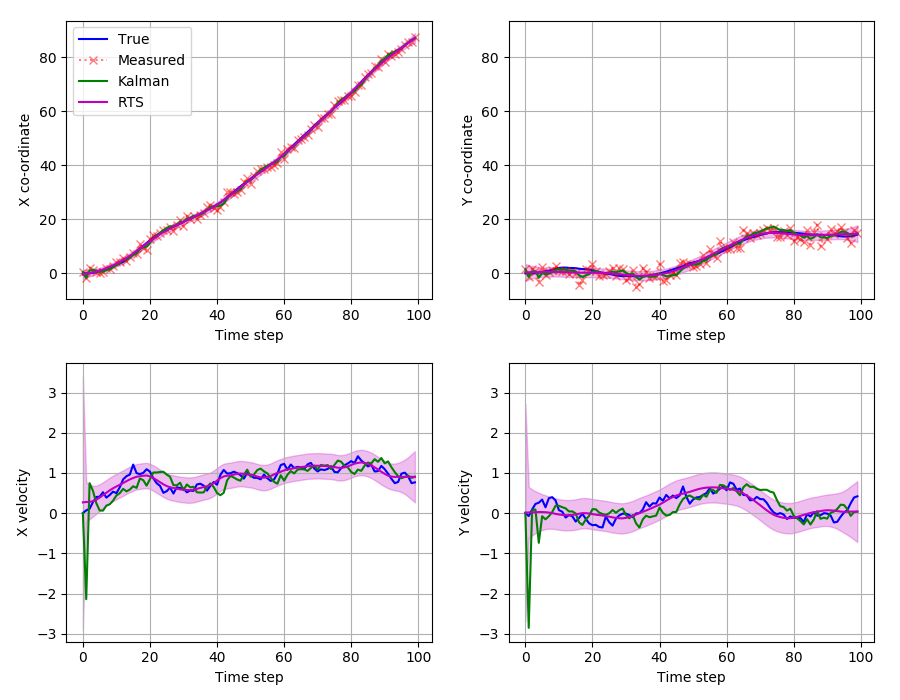

In [14]:
rts_states = vstack(d.mean for d in rts_estimates)
rts_covs = vstack(d.cov[newaxis, ...] for d in rts_estimates)
assert rts_states.shape == (N, STATE_DIM)
assert rts_covs.shape == (N, STATE_DIM, STATE_DIM)

# Plot the result
figure()
ax_x, ax_y, ax_vx, ax_vy = create_axes()
tight_layout()

sca(ax_x)
plot(true_states[:, 0], 'b', label="True")
plot(measurements[:, 0], 'rx:', label="Measured", alpha=0.5)
plot(estimates[:, 0], 'g', label="Kalman")
plot(rts_states[:, 0], 'm', label="RTS")
gca().autoscale(False)
plot_vars(ks, rts_states[:, 0], rts_covs[:, 0, 0],
          color='m', alpha=0.25, zorder=-1)
legend(loc="best")

sca(ax_y)
plot(true_states[:, 1], 'b', label="True")
plot(measurements[:, 1], 'rx:', label="Measured", alpha=0.5)
plot(estimates[:, 1], 'g', label="Estimated")
plot(rts_states[:, 1], 'm', label="Estimated")
gca().autoscale(False)
plot_vars(ks, rts_states[:, 1], rts_covs[:, 1, 1],
          color='m', alpha=0.25, zorder=-1)

sca(ax_vx)
plot(true_states[:, 2], 'b', label="True")
plot(estimates[:, 2], 'g', label="Estimated")
plot(rts_states[:, 2], 'm', label="RTS")
gca().autoscale(False)
plot_vars(ks, rts_states[:, 2], rts_covs[:, 2, 2],
          color='m', alpha=0.25, zorder=-1)

sca(ax_vy)
plot(true_states[:, 3], 'b', label="True")
plot(estimates[:, 3], 'g', label="Estimated")
plot(rts_states[:, 3], 'm', label="RTS")
gca().autoscale(False)
plot_vars(ks, rts_states[:, 3], rts_covs[:, 3, 3],
          color='m', alpha=0.25, zorder=-1)

We can see how the RTS smoothed states are far smoother than the forward
estimated states. But that the true state values are still very likely
to be within our three sigma band.